# Detection of change in stride length from gait

Pose estimation can be used to extract various metrics from a person's gait. This notebook demonstrates how the stride angle - the maximum angle between left and right leg over the course of a gait cycle - can be extracted from a video sequence. 

Stride angles can be collected over time and used to detect changes which might indicate increased physical fraility or an individual dealing with pain.

In [1]:
import sys
sys.path.append('../tf-pose-estimation')
import pandas as pd
import cv2
from gait_metrics import get_pose_estimator, get_stride_angle
from dft_analysis import dft_analysis, plot_angles
import matplotlib.pyplot as plt
%matplotlib inline

### Pose Estimation and Gait Metrics

We suppose that we have collected videos of an individual over time. Each video contains a cross-view of a person walking across a room. For each video we run pose estimation and then extract the angle between the left and right legs. This produces a (noisy) time-series of stride angles.

Below we demonstrate the processing and output from one such video. Note: Ensure video_path points to a valid video.

[2019-02-07 11:45:45,067] [TfPoseEstimator] [INFO] loading graph from C:\Users\MIRA 3\Desktop\tf-pose-estimation\models\graph/mobilenet_thin/graph_opt.pb(default size=432x368)


Text(0, 0.5, 'Stride Angle (deg)')

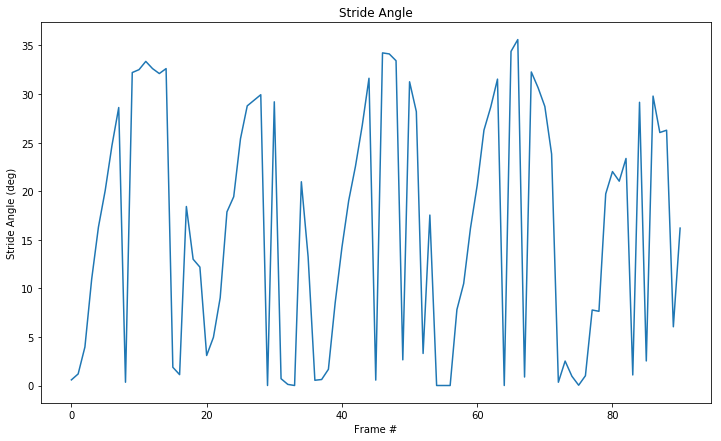

In [2]:
video_path = 'data/videos/robin_week_1.mov'
start = 60
end   = 150

e = get_pose_estimator()
resize_out_ratio = 8.0
video = cv2.VideoCapture(video_path)
angles = []
frame_count = 0
angle = 0.
while True:
    ok, frame = video.read()
    if not ok:
        break
    frame_count += 1
    if frame_count < start or frame_count > end:
        continue
    humans = e.inference(frame, resize_to_default=True, upsample_size=resize_out_ratio)
    if len(humans) > 0:
        angle = get_stride_angle(humans[0])
    angles.append(angle)
plt.figure(figsize=[12, 7])
plt.plot(angles)
plt.title('Stride Angle')
plt.xlabel('Frame #')
plt.ylabel('Stride Angle (deg)')


The graph above shows the stride angle metric detected in each frame. Although the subject in the video only takes 5 paces it's clear that the metric is very 'noisy'. This is because the Deep Learning model used for human detection can either fail to detect a human in a frame or else makes mistakes such as confusing left for right leg. 

### Extract maximum stride angles

Given this noisy dataset of stride angles we can use Discrete Fourier Transform (DFT) to identify the underlying gait cycle.

Freq at max power: 1.6483516483516483


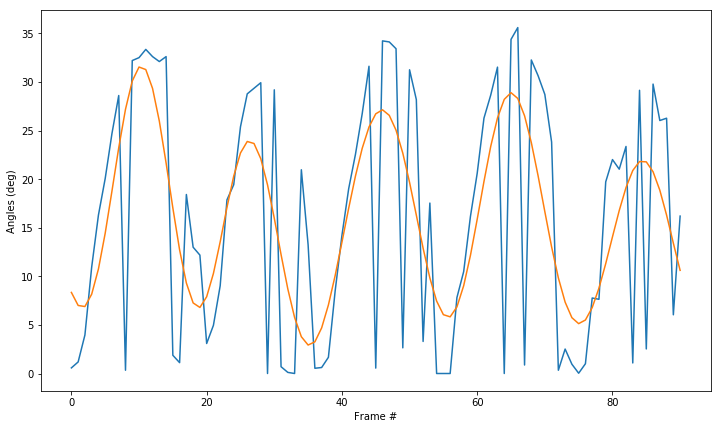

In [3]:
maxima, angles_smoothed, fft_freq = dft_analysis(angles, display_plots=False)
fig, ax = plt.subplots(1,1, figsize=[12,7])
plot_angles(angles, angles_smoothed, ax, display_minima=False)

We show the original metric from above in blue and overlay the main cycle obtained from DFT in orange.

We can now split up the the noisy dataset into each cycle and detect the maximum stride angle in each gait cycle.

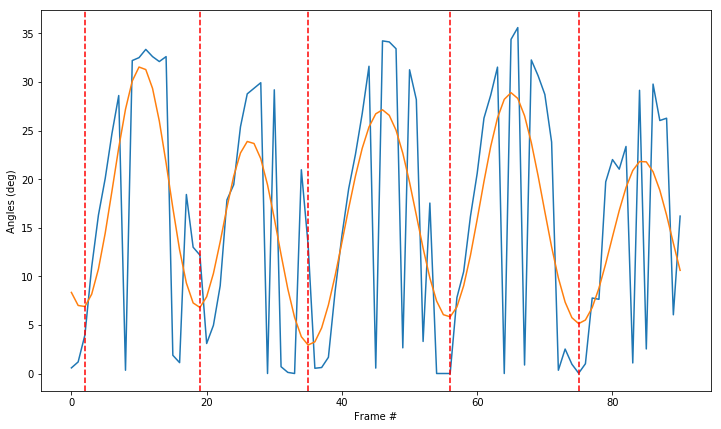

In [4]:
fig, ax = plt.subplots(1,1, figsize=[12,7])
plot_angles(angles, angles_smoothed, ax, display_minima=True)

### Analysis of stride length

With video sequences collected over time we can extract stride angles for each sequence and analyse as a time-series. 

Below we plot the median stride angle over time from a series of example video sequences. The video sequences were designed to exhibit an individual with the onset of physical fraility. We plot the stride angles and look for signs of deterioration.

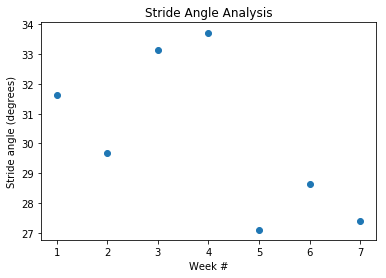

In [5]:
strides = pd.read_csv('stride_history.csv', header=None)
plt.scatter(range(1, len(strides)+1), strides)
plt.title('Stride Angle Analysis')
plt.xlabel('Week #')
plt.ylabel('Stride angle (degrees)')
plt.savefig('stride_analysis.png')

Of the 7 data points the last 3 indicates a significant change in the stride angle that should be a flag for further investigative action.